In [1]:
import caffe
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt
import cv2
from mvnc import mvncapi

NET_OUTPUT_SIZE = 707

In [2]:
net = caffe.Net('./models/maps/ssd-face-featmaps.prototxt',
                './models/deploy/ssd-face.caffemodel',
                caffe.TEST)

In [3]:
def transform_input(img, transpose=True, dtype=np.float32):
    inpt = cv2.resize(img, (300,300))
    inpt = inpt - 127.5
    inpt = inpt / 127.5
    inpt = inpt.astype(dtype)
    if transpose:
        inpt = inpt.transpose((2, 0, 1))
    return inpt

def transform_output(img, output):
    h,w = img.shape[:2] 
    boxes = (output['detection_out'][0,0,:,3:7] * np.array([w, h, w, h])).astype(int)
    classes = output['detection_out'][0,0,:,1].astype(int)
    confidence = output['detection_out'][0,0,:,2]
    if (len(confidence)==1) and (confidence[0]<0):
        return [],[],[]
    return boxes, classes, confidence

def transform_ncs_output(img, output, conf_thresh=0.5):
    """Get image and NCS output
    Return: boxes, classes, confidences"""
    num = int(output[0])
    scale = np.array([img.shape[1],img.shape[0],img.shape[1],img.shape[0]])
    t = [((e[3:].clip(0,1)*scale).astype(int), int(e[1]), e[2]) for e in output.reshape((-1,7))[1:] 
         if np.all(np.isfinite(e)) ][:num]
    #glitchy predictions with 1.0 confidence and 0 size in one/both dimensions appear sometimes
    #filter them too
    t = [e for e in t if (e[2]>conf_thresh) and (e[0][0]-e[0][2])*(e[0][1]-e[0][3])>0]
    return (zip(*t) if len(t)>0 else ([],[],[]))

def transform_featmaps(img, output, featmap_sizes=[19,10,5,3,2,1], nboxes=[2,2,2,2,2,2]):
    dets = output['detection_and_featmaps'][:,:-2000]
    dets = dets.ravel().reshape((1,1,dets.size//7, 7))
    fm = output['detection_and_featmaps'].ravel()[-2000::2]
    featmaps = []
    for s,n in zip(featmap_sizes, nboxes):
        t = 1-fm[:2*s**2].reshape(s,s,2)
        for i in range(n):
            featmaps.append(t[:,:,i])
        fm = fm[2*s**2:]
    a,b,c = transform_output(img, {'detection_out':dets})
    return a,b,c, featmaps

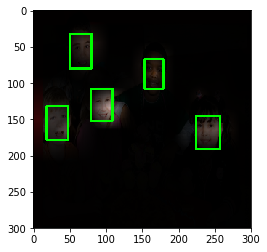

In [4]:
img = imread('./images/input/1.png')
img = cv2.resize(img,(300,300))

inpt = transform_input(img)
net.blobs['data'].data[...] = inpt
output = net.forward() 
boxes, classes, confidence, responses =transform_featmaps(img, output)

responses = [cv2.resize(e, (300,300)) for e in responses]
resp = np.zeros((300,300), dtype=float)
for e in responses:
    resp=np.maximum(e,resp)

img = (img*resp[:,:,None]).astype(np.uint8)

for box, cls, conf in zip(boxes, classes, confidence):
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.imshow(img)
plt.show()

/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:418: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)


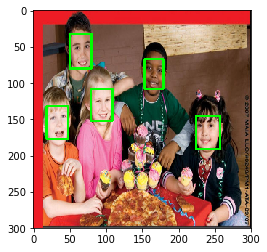

In [5]:
graph_path = './models/deploy/ssd-face.graph'
img = imread('./images/input/1.png')
img = cv2.resize(img,(300,300))

devices = mvncapi.enumerate_devices()
if len(devices) > 0:
    device = mvncapi.Device(devices[0])
    device.open()
    with open(graph_path, mode="rb") as f:
        graph_data = f.read()
    graph = mvncapi.Graph('graph_ssd')
    input_fifo, output_fifo = graph.allocate_with_fifos(device, graph_data)
    
    inpt = transform_input(img, False, np.float32)
    graph.queue_inference_with_fifo_elem(input_fifo, output_fifo, inpt, None)
    output, _ = output_fifo.read_elem()
    
    boxes, classes, confidence = transform_ncs_output(img, output, 0.25)
    
    for box, cls, conf in zip(boxes, classes, confidence):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
    plt.imshow(img)
    plt.show()

    input_fifo.destroy()
    output_fifo.destroy()
    graph.destroy()
    device.close()
    device.destroy()
else:
    print("No NCS device found")